# Overview
In these notebook all preparatory material for molecular evolution analyses are created. Posteriorly, parsing of results and plotting of this analyses as found in the paper are performed.

# Loading libraries

In [2]:
import glob, os, shutil
from multiprocessing import Pool

In [3]:
target_dirs = ['../results/molecular_evolution_analyses',
 '../results/molecular_evolution_analyses/homolog_groups',
 '../results/molecular_evolution_analyses/alignments',
 '../results/molecular_evolution_analyses/alignments_gblocks',
 '../results/molecular_evolution_analyses/codeml_results']

In [4]:
[os.mkdir(target) for target in target_dirs if not os.path.exists(target)]

[]

# Getting inparalogs and aligning them
Only inparalogs are aligned to perform the molecular evolution analyses.

In [2]:
import pandas as pd
import tqdm
from pathlib import Path
import pandas as pd
import os
from Bio import SeqIO

In [3]:
original2new = pd.read_csv('../results/misc/gene_code_correspondance.tsv', sep = '\t')
inparalog_groups = pd.read_csv('../results/misc/inparalogs_group_composition_final.tsv', sep = '\t')

In [6]:
def create_mapping_dict(original2new):
    """
    Creates a mapping dictionary from a DataFrame with columns 'Original Name' and 'New Name'.
    This is a placeholder to represent the logic since DataFrame operations are not executable here.
    """
    return pd.Series(original2new['New Name'].values, index=original2new['Original Name']).to_dict()

def optimized_translate_gene_names(genes, mapping):
    """
    Translates gene names based on a mapping dictionary. This version aims to be more efficient.
    """
    # Assuming genes are a string separated by ", "
    return ', '.join([mapping.get(gene, gene) for gene in genes.split(', ')])

def translate_genes_in_df(inparalog_groups, mapping_dict):
    """
    Applies gene name translation to a DataFrame column.
    This is a placeholder to represent the logic since DataFrame operations are not executable here.
    """
    inparalog_groups['Translated_Genes'] = inparalog_groups['Genes'].apply(lambda x: optimized_translate_gene_names(x, mapping_dict))
    return inparalog_groups

In [7]:
# Create the mapping dictionary
mapping_dict = create_mapping_dict(original2new)

In [8]:
base_dir = Path('../results/homolog_groups')
target_dir_base = Path('../results/molecular_evolution_analyses/homolog_groups')

def filter_and_write_sequences(original_file_path, new_file_path, gene_list):
    """
    Filters sequences based on a provided gene list and writes them to a new file.
    
    Args:
    original_file_path (Path): Path to the original FASTA file.
    new_file_path (Path): Path where the filtered FASTA file will be saved.
    gene_list (list): List of gene names to include in the filtered file.
    """
    # Read the original FASTA file
    original_sequences = SeqIO.parse(str(original_file_path), 'fasta')
    # Filter sequences
    filtered_sequences = (seq for seq in original_sequences if seq.id in gene_list)
    # getting name right
    #for seq in filtered_sequences:
    #    seq.id = seq.id.split(' ')[0]
    # Write filtered sequences to a new file
    new_file_path.parent.mkdir(parents=True, exist_ok=True)  # Ensure the target directory exists
    SeqIO.write(filtered_sequences, str(new_file_path), 'fasta')

# Process each inparalog group, now with translated gene names
for index, row in tqdm.tqdm(inparalog_groups.iterrows()):
    family_code = row['monophyletic_group_code'].split('_')[0]
    
    # Translate gene names using the mapping dictionary
    original_gene_list = row['Genes'].split(', ')  # Assuming 'Genes' column contains genes separated by ", "
    translated_gene_list = [mapping_dict.get(gene, gene) for gene in original_gene_list]
    
    original_file_path = base_dir / f'{family_code}.faa'
    new_file_path = target_dir_base / f'{row["monophyletic_group_code"]}.faa'
    
    if original_file_path.exists():
        # Filter and write sequences with translated gene names
        filter_and_write_sequences(original_file_path, new_file_path, translated_gene_list)
    else:
        print(f"File not found for {family_code}, skipped.")

19432it [00:06, 3042.00it/s]


KeyboardInterrupt: 

In [ ]:
import os
import glob
import tqdm
from concurrent.futures import ThreadPoolExecutor
from Bio import SeqIO

# Define a function to execute muscle command
def run_muscle(homolog_group):
    HG_name = homolog_group.rpartition('/')[2].rpartition('.')[0]
    aln_name = f'../results/molecular_evolution_analyses/alignments/{HG_name}.aln'
    if not os.path.exists(aln_name):
        # Check number of records
        num_records = sum(1 for record in SeqIO.parse(homolog_group, 'fasta'))
        if num_records >= 2:
            if not os.path.exists(aln_name):
                os.system(f"muscle -maxiters 1 -diags -sv -distance1 kbit20_3 -in {homolog_group} -out {aln_name}")

# Get list of homolog groups
homolog_groups = glob.glob('../results/molecular_evolution_analyses/homolog_groups/*')

# Use ThreadPoolExecutor for parallel execution
with ThreadPoolExecutor() as executor:
    # Map the function to the list of homolog groups
    list(tqdm.tqdm(executor.map(run_muscle, homolog_groups), total=len(homolog_groups)))

# Creating back-translated alignments

In [15]:
def process_alignment(aln_file):
    # Get family name
    family_name = aln_file.rpartition('/')[2].rpartition('.')[0]
    # Create directory for family in alignments_gblocks
    family_dir = f"../results/molecular_evolution_analyses/alignments_gblocks/{family_name}"
    os.makedirs(family_dir, exist_ok=True)
    # Run Gblocks command
    cmd = f"Gblocks {aln_file} -e=.gblo -b3=15 -d=y -a=y -k=y"
    os.system(cmd)
    # move
    %system mv {aln_file}.gblo* {family_dir}

In [16]:
# Create directory for alignments_gblocks
os.makedirs("../results/alignments_gblocks", exist_ok=True)

# Get list of alignment files
alignment_files = glob.glob("../results/molecular_evolution_analyses/alignments/*.aln")

In [17]:
# Create Pool with 32 processes
with Pool(32) as pool:
    pool.map(process_alignment, alignment_files)

In [18]:
import os
import glob,tqdm
from Bio import SeqIO
from concurrent.futures import ThreadPoolExecutor

In [19]:
def process_alignment(aln_file):
    family_name = aln_file.rpartition('/')[2].rpartition('.')[0]
    family_dir = f"../results/molecular_evolution_analyses/alignments_gblocks/{family_name}"
    os.makedirs(family_dir, exist_ok=True)
    
    # Load record IDs present in the alignment while maintaining order
    record_ids = []
    with open(aln_file, 'r') as f:
        for line in f:
            if line.startswith('>'):
                record_id = line.strip()[1:].split(' ')[0]
                record_ids.append(record_id)
    
    # Save sequences into a file with the same order as in the alignment
    output_file = os.path.join(family_dir, f"{family_name}.CDS_transcripts.fna")
    with open(output_file, 'w') as f:
        for record_id in record_ids:
            if record_id in sequences_dict:
                SeqIO.write(sequences_dict[record_id], f, 'fasta')

In [20]:
# Get the sequences from CDS files into a dictionary
sequences_dict = {}
cds_files = glob.glob('../data/platyhelminthes_dataset_vfinal/*longest*CDS*.fna')
for cds_file in tqdm.tqdm(cds_files):
    sequences = SeqIO.to_dict(SeqIO.parse(cds_file, 'fasta'))
    sequences_dict.update(sequences)

# Get the alignment files
alignment_files = glob.glob('../results/molecular_evolution_analyses/alignments/*')

100%|██████████| 21/21 [00:05<00:00,  3.92it/s]


In [21]:
# Process alignment files in parallel
num_threads = 32
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    executor.map(process_alignment, alignment_files)

In [22]:
# back translating with pal2nal

In [23]:
import concurrent
import concurrent.futures

In [24]:
#def process_file(aln_gbloMask):
#    family_name = os.path.basename(os.path.dirname(aln_gbloMask))
#    filtered_file = f"../results/alignments_gblocks/{family_name}/{family_name}.gbloMask_filtrada"
#    # Prepare the shell command
#    %system cat {aln_gbloMask} | sed 's/>..*/&_____/g' | sed ':a;N;$!ba;s/\n//g' | sed 's/_____/\n/g' | sed 's/>/\n>/g' | egrep . | grep -v \"Mask\" | grep -v \"@\" | sed 's/>.*Gblocks/>/g' | sed 's/P.*;//g' > {filtered_file}
#
## List all gbloMask files
#gbloMask_files = glob.glob('../results/alignments_gblocks/*/*.gbloMask')
#
#for file in tqdm.tqdm(gbloMask_files):
#    process_file(file)
#
## Use ThreadPoolExecutor to parallelize the file processing
##with concurrent.futures.ThreadPoolExecutor(max_workers=32) as executor:
##    list(tqdm.tqdm(executor.map(process_file, gbloMask_files), total=len(gbloMask_files)))

In [25]:
## Pattern to match the files of interest
#pattern = '../results/alignments_gblocks/*/*.gbloMask_filtrada'
#
## Use glob to find files matching the pattern
#files = glob.glob(pattern, recursive=True)
#
## List to hold paths of empty files
#empty_files = []
#
## Check each file
#for file_path in files:
#    # Check if the file is empty by reading its size
#    if os.path.getsize(file_path) == 0:
#        empty_files.append(file_path)
#
## Print the paths of empty files
#if empty_files:
#    print("Empty files found:")
#    for file_path in empty_files:
#        print(file_path)
#else:
#    print("No empty files found.")

In [26]:
#gbloMask_filtered_files = glob.glob('../results/alignments_gblocks/*/*.gbloMask_filtrada')
#
#def is_valid_sequence(seq):
#    """Check if the sequence contains only '#' and '*'."""
#    return not all(c in '#*' for c in seq)
#
#def filter_alignment(alignment):
#    """Filter out sequences consisting only of '#' and '*'."""
#    return [record for record in alignment if is_valid_sequence(record.seq)]
#
#def process_file(input_file):
#    try:
#        # Load the alignment
#        alignment = AlignIO.read(input_file, 'fasta')
#        # Filter the alignment
#        filtered_alignment = filter_alignment(alignment)
#        # Define the output file name
#        output_file = f'{input_file}_clean.clustal'
#        # Save the cleaned alignment
#        with open(output_file, 'w') as outfile:
#            AlignIO.write(filtered_alignment, outfile, 'clustal')
#        return f"Processed {input_file}"
#    except Exception as e:
#        return f"Problem with {input_file}: {e}"
#
## Using ThreadPoolExecutor to process files in parallel
#with ThreadPoolExecutor(max_workers=32) as executor:
#    # Wrapping tqdm around executor.map to display progress
#    results = list(tqdm.tqdm(executor.map(process_file, gbloMask_filtered_files), total=len(gbloMask_filtered_files)))

In [27]:
# Pattern to match the files of interest
pattern = '../results/alignments_gblocks/*/*.gblo'

# Use glob to find files matching the pattern
files = glob.glob(pattern, recursive=True)

# List to hold paths of empty files
empty_files = []

# Check each file
for file_path in files:
    # Check if the file is empty by reading its size
    if os.path.getsize(file_path) == 0:
        empty_files.append(file_path)

# Print the paths of empty files
if empty_files:
    print("Empty files found:")
    for file_path in empty_files:
        print(file_path)
else:
    print("No empty files found.")

No empty files found.


In [28]:
from Bio import AlignIO

# Step 2: Transform filtered files from FASTA to CLUSTAL format
for filtered_file in tqdm.tqdm(glob.glob('../results/molecular_evolution_analyses/alignments_gblocks/*/*.gblo')):
    try:
        clustal_file = f"{filtered_file}.clustal.aln"
        # Read the filtered file in FASTA format
        alignment = AlignIO.read(filtered_file, 'fasta')
        # Write the alignment to a file in CLUSTAL format
        AlignIO.write(alignment, clustal_file, 'clustal')
    except Exception as e:
        print(e, filtered_file)

  5%|▍         | 958/19962 [00:00<00:09, 2019.34it/s]

Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F68562_HDIM_G1/F68562_HDIM_G1.aln.gblo
Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F110517_HDIM_G1/F110517_HDIM_G1.aln.gblo
Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F18961_HDIM_G1/F18961_HDIM_G1.aln.gblo
Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F34729_HDIM_G1/F34729_HDIM_G1.aln.gblo


 20%|██        | 4009/19962 [00:01<00:03, 4686.33it/s]

Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F39095_SMED_G1/F39095_SMED_G1.aln.gblo
Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F58197_HDIM_G1/F58197_HDIM_G1.aln.gblo


 28%|██▊       | 5596/19962 [00:01<00:02, 5093.13it/s]

Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F128898_SMED_G1/F128898_SMED_G1.aln.gblo


 33%|███▎      | 6627/19962 [00:01<00:02, 5071.60it/s]

Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F109682_SMED_G1/F109682_SMED_G1.aln.gblo
Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F94326_SMED_G1/F94326_SMED_G1.aln.gblo
Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F115802_HDIM_G1/F115802_HDIM_G1.aln.gblo
Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F1280_MCOR_G1/F1280_MCOR_G1.aln.gblo


 44%|████▎     | 8705/19962 [00:02<00:02, 5166.80it/s]

Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F119226_MCOR_G1/F119226_MCOR_G1.aln.gblo
Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F17052_HDIM_G1/F17052_HDIM_G1.aln.gblo
Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F60779_MCOR_G1/F60779_MCOR_G1.aln.gblo


 54%|█████▍    | 10817/19962 [00:02<00:01, 5238.13it/s]

Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F71059_HDIM_G1/F71059_HDIM_G1.aln.gblo


 59%|█████▉    | 11863/19962 [00:02<00:01, 5204.78it/s]

Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F82088_MCOR_G1/F82088_MCOR_G1.aln.gblo
Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F90094_SMED_G1/F90094_SMED_G1.aln.gblo


 70%|██████▉   | 13950/19962 [00:03<00:01, 5166.37it/s]

Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F92914_SMED_G1/F92914_SMED_G1.aln.gblo
Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F18500_SMED_G1/F18500_SMED_G1.aln.gblo
Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F104005_HDIM_G1/F104005_HDIM_G1.aln.gblo


 75%|███████▌  | 14994/19962 [00:03<00:00, 5191.15it/s]

Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F22403_HDIM_G1/F22403_HDIM_G1.aln.gblo
Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F80813_SMED_G1/F80813_SMED_G1.aln.gblo
Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F114270_HDIM_G1/F114270_HDIM_G1.aln.gblo
Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F21109_SMED_G1/F21109_SMED_G1.aln.gblo


 88%|████████▊ | 17604/19962 [00:03<00:00, 5212.89it/s]

Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F36958_SMED_G1/F36958_SMED_G1.aln.gblo


 96%|█████████▌| 19165/19962 [00:04<00:00, 5113.81it/s]

Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F82571_MCOR_G1/F82571_MCOR_G1.aln.gblo


100%|██████████| 19962/19962 [00:04<00:00, 4485.76it/s]

Non-empty sequences are required ../results/molecular_evolution_analyses/alignments_gblocks/F112254_HDIM_G1/F112254_HDIM_G1.aln.gblo


___
**Note**: it was checked by visual inspection that, indeed, in some cases no file is generated by Gblocks because the resulting alignment isnt suitable according to the employed criteria.
___

In [29]:
# Step 4: Run pal2nal over CLUSTAL files
for clustal_file in tqdm.tqdm(glob.glob('../results/molecular_evolution_analyses/alignments_gblocks/*/*.gblo.clustal.aln')):
    family_name = os.path.basename(os.path.dirname(clustal_file))
    # Get the corresponding CDS file in the family folder
    cds_file = f"../results/molecular_evolution_analyses/alignments_gblocks/{family_name}/{family_name}.CDS_transcripts.fna"
    # Execute the shell command to run pal2nal
    %system pal2nal.pl {clustal_file} {cds_file} -output paml -blockonly > {clustal_file}.paml

100%|██████████| 19962/19962 [23:37<00:00, 14.08it/s]


In [30]:
# Pattern to match the files of interest
pattern = '../results/molecular_evolution_analyses/alignments_gblocks/*/*.paml'

# Use glob to find files matching the pattern
files = glob.glob(pattern, recursive=True)

# List to hold paths of empty files
empty_files = []

# Check each file
for file_path in files:
    # Check if the file is empty by reading its size
    if os.path.getsize(file_path) == 0:
        empty_files.append(file_path)

# Print the paths of empty files
if empty_files:
    print("Empty files found:")
    for file_path in empty_files:
        print(file_path)
else:
    print("No empty files found.")

Empty files found:
../results/molecular_evolution_analyses/alignments_gblocks/F53749_MLIG_G1/F53749_MLIG_G1.aln.gblo.clustal.aln.paml
../results/molecular_evolution_analyses/alignments_gblocks/F103102_MLIG_G1/F103102_MLIG_G1.aln.gblo.clustal.aln.paml
../results/molecular_evolution_analyses/alignments_gblocks/F32059_TREG_G1/F32059_TREG_G1.aln.gblo.clustal.aln.paml
../results/molecular_evolution_analyses/alignments_gblocks/F8315_TASI_G1/F8315_TASI_G1.aln.gblo.clustal.aln.paml
../results/molecular_evolution_analyses/alignments_gblocks/F71368_SHAE_G1/F71368_SHAE_G1.aln.gblo.clustal.aln.paml
../results/molecular_evolution_analyses/alignments_gblocks/F109937_SMED_G1/F109937_SMED_G1.aln.gblo.clustal.aln.paml
../results/molecular_evolution_analyses/alignments_gblocks/F97422_MLIG_G1/F97422_MLIG_G1.aln.gblo.clustal.aln.paml
../results/molecular_evolution_analyses/alignments_gblocks/F27079_MLIG_G1/F27079_MLIG_G1.aln.gblo.clustal.aln.paml
../results/molecular_evolution_analyses/alignments_gblocks/

# Running phylogenetic inferences

This was done using a script that performs parallel computer (found in this folder).

## Creating dummy trees for one-species-groups
If a homologous group is conformed only by one species, then by definition their members are inparalogs. If these groups are of size n=2, n=3 or n=4 no tree can be inferred, but they dummy trees can be created in order to input them into the analyses.

In [34]:
from ete3 import Tree
import glob
from Bio import SeqIO

In [35]:
# defining used species_codes
species_codes = [x.rpartition('/')[2].split('.')[0].split('_')[0].title()[0]+x.rpartition('/')[2].split('.')[0].split('_')[1][0:3] for x in glob.glob('../data/platyhelminthes_dataset/*.faa')]

In [36]:
import os
import glob
from ete3 import Tree

alignment_dir = '../results/molecular_evolution_analyses/alignments_gblocks'
output_dir = '../results/molecular_evolution_analyses/phylogenetic_trees'

for aln_file in glob.glob(os.path.join(alignment_dir, '*/*.gblo')):
    if os.path.getsize(aln_file) != 0:
        # Get record ids in the alignment
        with open(aln_file, 'r') as f:
            alignment = f.readlines()
    
        record_ids = set()
        for line in alignment:
            if line.startswith('>'):
                record_id = line.strip().split()[0][1:]  # remove '>' and split by space
                record_ids.add(record_id)
    
        # If the alignment has 2, 3 or 4 sequences, continue analyzing
        if (3 <= len(record_ids) <= 4) or (len(record_ids) == 2):
            # Get set of species in the alignment
            species_set = set([record.split('.')[0] for record in record_ids])
    
            # If only one species is present, create a dummy Tree with ete3
            if len(species_set) == 1:
                tree = Tree()
                for record in record_ids:
                    tree.add_child(name=record) 
    
                # Get the homologs family name
                homolog_family_name = os.path.splitext(os.path.basename(aln_file))[0]
                homolog_family_name = homolog_family_name.replace('.aln', '')
                # Export the dummy tree
                output_folder = os.path.join(output_dir, homolog_family_name)
                os.makedirs(output_folder, exist_ok=True)
                output_tree_path = os.path.join(output_folder, f"{homolog_family_name}.tree")
                tree.write(outfile=output_tree_path)
    
                print(f"Dummy tree created for {homolog_family_name} in {output_tree_path}")
    

Dummy tree created for F53749_MLIG_G1 in ../results/molecular_evolution_analyses/phylogenetic_trees/F53749_MLIG_G1/F53749_MLIG_G1.tree
Dummy tree created for F85516_SMED_G1 in ../results/molecular_evolution_analyses/phylogenetic_trees/F85516_SMED_G1/F85516_SMED_G1.tree
Dummy tree created for F59624_MLIG_G1 in ../results/molecular_evolution_analyses/phylogenetic_trees/F59624_MLIG_G1/F59624_MLIG_G1.tree
Dummy tree created for F23474_MLIG_G1 in ../results/molecular_evolution_analyses/phylogenetic_trees/F23474_MLIG_G1/F23474_MLIG_G1.tree
Dummy tree created for F19661_MLIG_G1 in ../results/molecular_evolution_analyses/phylogenetic_trees/F19661_MLIG_G1/F19661_MLIG_G1.tree
Dummy tree created for F31918_MLIG_G1 in ../results/molecular_evolution_analyses/phylogenetic_trees/F31918_MLIG_G1/F31918_MLIG_G1.tree
Dummy tree created for F114603_HMIC_G1 in ../results/molecular_evolution_analyses/phylogenetic_trees/F114603_HMIC_G1/F114603_HMIC_G1.tree
Dummy tree created for F121871_SCUR_G9 in ../results

# Running positive-selection analyses

# Parsing results

In [1]:
import pandas as pd
import glob
import subprocess
import re
import os
from scipy.stats import chi2
import numpy as np
import concurrent.futures

# Parser functions (assuming these are defined as provided in your original script)
def parserW(mlc):
    command = f"grep 'w:' {mlc}"
    output = subprocess.check_output(command, shell=True).decode('utf-8').strip()
    values = re.split("\s+", output)
    values = [val for val in values if val]
    return values

import pandas as pd
import re
from pathlib import Path

import pandas as pd
from pathlib import Path

def parse_dNs(mlc_file):
    capture = False
    data = []
    with open(mlc_file, 'r') as file:
        for line in file:
            if 'dN & dS for each branch' in line:
                capture = True
                continue
            elif 'Naive Empirical Bayes' in line:
                capture = False
                break
            if capture and line.strip() and not line.strip().startswith('branch'):
                parts = line.split()
                if len(parts) == 9:  # Ensure we're capturing the correct number of elements
                    data.append(parts[1:])  # Skip the branch label part for now

    columns = ['t', 'N', 'S', 'dN/dS', 'dN', 'dS', 'N*dN', 'S*dS']
    df = pd.DataFrame(data, columns=columns)
    df[['t', 'N', 'S', 'dN/dS', 'dN', 'dS', 'N*dN', 'S*dS']] = df[['t', 'N', 'S', 'dN/dS', 'dN', 'dS', 'N*dN', 'S*dS']].apply(pd.to_numeric)
    return df

def parser_dNs_complete(out_file):
    df = parse_dNs(out_file)
    # Handling cases where both dN and dS are zero
    df['dn_ds_calculated'] = df.apply(lambda x: x['dN/dS'] if (x['dS'] == 0 and x['dN'] == 0) else (x['dN'] / x['dS'] if x['dS'] != 0 else pd.NA), axis=1)
    # Calculate differences only where dn_ds_calculated is not NA
    df['dn_ds_diff'] = df.apply(lambda x: abs(x['dN/dS'] - x['dn_ds_calculated']) if pd.notna(x['dn_ds_calculated']) else pd.NA, axis=1)
    # Add file info
    df['file_info'] = Path(out_file).name

    # Filter and sort by smallest difference where calculated dN/dS is available
    df_filtered = df.dropna(subset=['dn_ds_calculated'])
    if not df_filtered.empty:
        df_filtered = df_filtered.sort_values(by='dn_ds_diff').iloc[0]
        return (float(df_filtered['dN']), float(df_filtered['dS']), float(df_filtered['dN/dS']))
    else:
        return (pd.NA, pd.NA, pd.NA)

def parser_sitios_BEB(mlc):
    try:
        command = f"sed -n '/Bayes Empirical Bayes (BEB) analysis/,/The grid (see ternary graph for p0-p1).*$/p' {mlc} | grep -v 'Bayes' | grep -v '^$' | grep -v 'Positively' | grep -v 'amino' | grep -v 'The grid'"
        output = subprocess.check_output(command, shell=True).decode('utf-8').strip().split('\n')
        output = [x for x in output if x]  # Remove empty strings
        
        # Parse the output and create a list of dictionaries for DataFrame construction
        data = []
        for line in output:
            if line.strip() and not line.startswith("Pr(w>1)"):
                parts = line.split()
                site = ' '.join(parts[:2])
                pr = parts[2]
                post_mean_se = ' '.join(parts[3:])
                data.append({'Site': site, 'Pr(w>1)': pr, 'post mean +- SE for w': post_mean_se})
        
        df = pd.DataFrame(data)

        # Add the new columns based on the conditions
        df['Site under selection (BEB pp > 0.95)'] = df['Pr(w>1)'].apply(lambda x: '*' in x)
        df['Site under strong selection (BEB pp > 0.95)'] = df['Pr(w>1)'].apply(lambda x: '**' in x)

        return df
    except Exception as e:
        # It's generally a good idea to print/log the exception to understand why it failed
        #print(f"Error processing file {mlc}: {e}")
        return pd.DataFrame({'Site': ['-'], 'Pr(w>1)': ['-'], 'post mean +- SE for w': ['-'],
                             'Site under selection (BEB pp > 0.95)': [False],
                             'Site under strong selection (BEB pp > 0.95)': [False]})



def lector_lnL(archivo_mlc):
    command = f"grep 'lnL' {archivo_mlc}"
    output = subprocess.check_output(command, shell=True).decode('utf-8').strip()
    lnL = float(re.search(r"\):\s+([-\d\.]+)", output).group(1))
    return lnL

def lector_np(archivo_mlc):
    command = f"grep 'lnL' {archivo_mlc}"
    output = subprocess.check_output(command, shell=True).decode('utf-8').strip()
    match = re.search(r"np:\s+(\d+)", output)
    if match:
        np = int(match.group(1))
        return np
    else:
        # Handle the case where no match is found
        # Option 1: Return a default value, such as 0 or None
        return None
        # Option 2: Raise an informative error
        # raise ValueError(f"No 'np' value found in file: {archivo_mlc}")

def LRT(lnL_1, lnL_2, grados_libertad):
    LR = 2 * (lnL_2 - lnL_1)
    chi = chi2.ppf(0.95, df=grados_libertad)
    significativo = 1 if LR > chi else 0
    return pd.DataFrame({'Likelihood_ratio': [LR], 'Grados_de_libertad': [grados_libertad], 'chi_2': [chi], 'Significativo': [significativo]})

import os
import pandas as pd

def extract_data_from_model_folder(folder_path, model_type):
    """
    Extracts data from a given model type (M1 or M2) within a specified folder path.
    """
    # Assuming 'out' and 'rst' files naming convention
    filepath_out = os.path.join(folder_path, 'out')
    filepath_rst = os.path.join(folder_path, 'rst')
    
    parsed_data = {
        'Family': os.path.basename(os.path.dirname(folder_path)),
        'Model': model_type,
        'Degrees of freedom': None,
        'LnL': None,
        '# sites (BEB pp > 0.95)': 0,  # New key for counting
        '# sites (BEB pp > 0.99)': 0,  # New key for counting
        'dN': None,
        'dS': None,
        'dN/dS': None
    }
    
    # Parse LnL and degrees of freedom from 'out' file
    parsed_data['LnL'] = lector_lnL(filepath_out)
    parsed_data['Degrees of freedom'] = lector_np(filepath_out)
    dN,dS,dNdS = parser_dNs_complete(filepath_out)
    parsed_data['dN/dS'] = float(dNdS)
    parsed_data['dN'] = float(dN)
    parsed_data['dS'] = float(dS)
    
    # For model M2, parse additional data
    if model_type == 'M2':
        # Parse BEB sites data from the 'rst' file
        beb_data = parser_sitios_BEB(filepath_out)
        if not beb_data.empty:
            parsed_data['Num. sites (BEB pp > 0.95)'] = beb_data['Site under selection (BEB pp > 0.95)'].sum()
            parsed_data['Num. sites (BEB pp > 0.99)'] = beb_data['Site under strong selection (BEB pp > 0.95)'].sum()

    return parsed_data


def process_model_folders(model_folders):
    data = []
    for model_folder in model_folders:
        # Determine model type based on folder name
        model_type = 'M1' if 'M1' in os.path.basename(model_folder) else 'M2'
        model_data = extract_data_from_model_folder(model_folder, model_type)
        data.append(model_data)
    return data

def process_family_folder(family_folder):
    try:
        model_folders = glob.glob(os.path.join(family_folder, 'M[12]*'))
        data = process_model_folders(model_folders)
        return data, None  # Return None for error if successful
    except Exception as e:
        return None, family_folder  # Return the folder as an error if failure

def process_family_folders_concurrently(base_folder):
    family_folders_pattern = os.path.join(base_folder, '*/*')
    family_folders = glob.glob(family_folders_pattern)

    data = []
    error_folders = []  # Initialize an empty list to collect folders that could not be processed
    with concurrent.futures.ThreadPoolExecutor(max_workers=32) as executor:
        future_to_folder = {executor.submit(process_family_folder, family_folder): family_folder for family_folder in family_folders}
        for future in concurrent.futures.as_completed(future_to_folder):
            family_data, error = future.result()
            if family_data:
                data.extend(family_data)
            if error:
                error_folders.append(error)  # Append the folder name to the list if there was an error

    return pd.DataFrame(data), error_folders


In [2]:
base_folder = '../results/molecular_evolution_analyses/codeml_results'
df, error_folders = process_family_folders_concurrently(base_folder)
if error_folders:
    print("The following folders could not be processed due to errors:")
    for folder in error_folders:
        print(folder)


The following folders could not be processed due to errors:
../results/molecular_evolution_analyses/codeml_results/F107659_MLIG_G1/F107659_MLIG_G1
../results/molecular_evolution_analyses/codeml_results/F124428_TSAG_G1/F124428_TSAG_G1
../results/molecular_evolution_analyses/codeml_results/F5309_SMED_G1/F5309_SMED_G1
../results/molecular_evolution_analyses/codeml_results/F23672_HMIC_G1/F23672_HMIC_G1
../results/molecular_evolution_analyses/codeml_results/F56005_MLIG_G1/F56005_MLIG_G1
../results/molecular_evolution_analyses/codeml_results/F88144_SMED_G1/F88144_SMED_G1
../results/molecular_evolution_analyses/codeml_results/F53532_MLIG_G1/F53532_MLIG_G1
../results/molecular_evolution_analyses/codeml_results/F15059_SMED_G1/F15059_SMED_G1
../results/molecular_evolution_analyses/codeml_results/F30181_MLIG_G1/F30181_MLIG_G1
../results/molecular_evolution_analyses/codeml_results/F126163_SMED_G1/F126163_SMED_G1
../results/molecular_evolution_analyses/codeml_results/F12776_MLIG_G1/F12776_MLIG_G1
.

In [3]:
df.head()

,Family,Model,Degrees of freedom,LnL,# sites (BEB pp > 0.95),# sites (BEB pp > 0.99),dN,dS,dN/dS,Num. sites (BEB pp > 0.95),Num. sites (BEB pp > 0.99)
0,F79292_TASI_G1,M2,8.0,-561.882470,0,0,0.0,0.0,0.5359,0.0,0.0
1,F79292_TASI_G1,M1,6.0,-561.882472,0,0,0.0,0.0,0.5359,NaN,NaN
2,F8315_TASI_G1,M1,5.0,-75.424929,0,0,0.0,0.0,0.3477,NaN,NaN
3,F8315_TASI_G1,M2,7.0,-75.424872,0,0,0.0,0.0,0.0000,0.0,0.0
4,F31918_MLIG_G1,M2,8.0,-1319.539216,0,0,0.0,0.0,0.7685,0.0,0.0


In [6]:
extract_data_from_model_folder('../results/molecular_evolution_analyses/codeml_results/F19661_MLIG_G1/F19661_MLIG_G1/M2~4ac819279cbba129ddef4b281ac57785/', 'M2')

{'Family': 'M2~4ac819279cbba129ddef4b281ac57785',
 'Model': 'M2',
 'Degrees of freedom': 8,
 'LnL': -502.479064,
 '# sites (BEB pp > 0.95)': 0,
 '# sites (BEB pp > 0.99)': 0,
 'dN': 0.0,
 'dS': 0.0,
 'dN/dS': 16.7968,
 'Num. sites (BEB pp > 0.95)': 2,
 'Num. sites (BEB pp > 0.99)': 2}

In [10]:
df

,Family,Model,Degrees of freedom,LnL,# sites (BEB pp > 0.95),# sites (BEB pp > 0.99),dN,dS,dN/dS,Num. sites (BEB pp > 0.95),Num. sites (BEB pp > 0.99)
0,F79292_TASI_G1,M2,8.0,-561.882470,0,0,0.0000,0.0000,0.5359,0.0,0.0
1,F79292_TASI_G1,M1,6.0,-561.882472,0,0,0.0000,0.0000,0.5359,NaN,NaN
2,F8315_TASI_G1,M1,5.0,-75.424929,0,0,0.0000,0.0000,0.3477,NaN,NaN
3,F8315_TASI_G1,M2,7.0,-75.424872,0,0,0.0000,0.0000,0.0000,0.0,0.0
4,F31918_MLIG_G1,M2,8.0,-1319.539216,0,0,0.0000,0.0000,0.7685,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
39787,F114209_MLIG_G1,M2,9.0,-213.669409,0,0,0.0000,0.0734,0.0000,0.0,0.0
39788,F80846_MLIG_G1,M1,6.0,-1722.066589,0,0,0.0036,0.0066,0.5450,NaN,NaN
39789,F80846_MLIG_G1,M2,8.0,-1718.970376,0,0,0.0241,0.0079,3.0504,0.0,0.0
39790,F86787_TREG_G1,M2,7.0,-697.109505,0,0,0.0000,0.0000,0.1047,0.0,0.0


In [11]:
parser_dNs_complete('../results/molecular_evolution_analyses/codeml_results/F19661_MLIG_G1/F19661_MLIG_G1/M2~4ac819279cbba129ddef4b281ac57785/out')

(0.0, 0.0, 16.7968)

In [12]:
df.to_csv('../results/molecular_evolution_analyses/codeml_results/codeml_results_raw.tsv', sep = '\t', index = False)

In [13]:
df = pd.read_csv('../results/molecular_evolution_analyses/codeml_results/codeml_results_raw.tsv', sep = '\t')

In [14]:
from multiprocessing import Pool, cpu_count
import pandas as pd
from scipy.stats import chi2

def LRT(lnl_m1, lnl_m2, df):
    lr = 2 * (lnl_m2 - lnl_m1)
    p_value = chi2.sf(lr, df)
    significativo = 1 if p_value < 0.05 else 0
    return pd.DataFrame({'Likelihood_ratio': [lr], 'Significativo': [significativo]})

def calculate_LRT_for_group_safe(name_group):
    name, group = name_group
    group = group.sort_values('Model')
    m1_row = group[group['Model'] == 'M1']
    m2_row = group[group['Model'] == 'M2']
    
    if not m1_row.empty and not m2_row.empty and not pd.isnull(m1_row['Degrees of freedom'].values[0]) and not pd.isnull(m2_row['Degrees of freedom'].values[0]):
        df_difference = m2_row['Degrees of freedom'].values[0] - m1_row['Degrees of freedom'].values[0]
        if pd.notnull(df_difference):
            df = int(df_difference)
            lrt_result = LRT(m1_row['LnL'].values[0], m2_row['LnL'].values[0], df)
            significative = '***' if lrt_result['Significativo'].values[0] == 1 else '-'
            
            return pd.Series({
                'Family': name,
                'Likelihood_ratio': lrt_result['Likelihood_ratio'].values[0],
                'Significativo': significative
            })
    return pd.Series({
        'Family': name,
        'Likelihood_ratio': None,
        'Significativo': None
    })

def apply_parallel(df_grouped, func):
    with Pool(cpu_count()) as pool:
        results = pool.map(func, [(name, group) for name, group in df_grouped])
    return pd.concat(results, axis=1).transpose()

In [15]:
# Grouping the DataFrame by 'Family' for parallel processing
df_grouped = df.groupby('Family')
# Applying the LRT calculation in parallel
lrt_results = apply_parallel(df_grouped, calculate_LRT_for_group_safe).reset_index()

In [16]:
lrt_results

,index,Family,Likelihood_ratio,Significativo
0,0,F100001_MLIG_G1,0.268468,-
1,1,F100009_MLIG_G1,0,-
2,2,F100010_MLIG_G1,0.499228,-
3,3,F100011_MLIG_G1,1e-05,-
4,4,F100014_MLIG_G1,0.00012,-
...,...,...,...,...
19891,19891,F99969_MLIG_G1,6e-06,-
19892,19892,F99980_SMED_G1,2e-06,-
19893,19893,F99982_SMAT_G1,0,-
19894,19894,F99995_MLIG_G1,69.987,***


In [17]:

# Merging the results back into the original DataFrame
df_merged = df.merge(lrt_results, on='Family', how='left')

In [18]:
df_merged.to_csv('../results/molecular_evolution_analyses/codeml_results/codeml_results.tsv', sep = '\t', index = False)

In [5]:
import pandas as pd
df_merged = pd.read_csv('../results/molecular_evolution_analyses/codeml_results/codeml_results.tsv', sep = '\t')

In [6]:
df_merged.query("Significativo == '***'").query("not `Num. sites (BEB pp > 0.95)`.isnull()").query("dS > 0.1 and `Num. sites (BEB pp > 0.95)` > 0").sort_values(by = 'Num. sites (BEB pp > 0.95)')

,Family,Model,Degrees of freedom,LnL,# sites (BEB pp > 0.95),# sites (BEB pp > 0.99),dN,dS,dN/dS,Num. sites (BEB pp > 0.95),Num. sites (BEB pp > 0.99),index,Likelihood_ratio,Significativo
15387,F7435_HDIM_G1,M2,8.0,-461.989852,0,0,0.5886,0.1039,5.6656,1.0,1.0,15639,12.257708,***
29827,F118714_SMAN_G1,M2,8.0,-1723.503908,0,0,0.1108,0.1481,0.7483,1.0,0.0,3164,8.598146,***
20638,F76087_TREG_G1,M2,7.0,-591.273429,0,0,0.3027,0.1555,1.9472,1.0,0.0,15923,7.125990,***
16279,F104876_SMED_G1,M2,9.0,-609.513178,0,0,0.1312,0.1222,1.0736,1.0,0.0,796,9.070758,***
33282,F85475_HDIM_G1,M2,7.0,-355.175927,0,0,5.7403,0.1533,37.4395,1.0,0.0,17487,7.044348,***
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35093,F101658_MLIG_G1,M2,9.0,-9137.764139,0,0,10.7153,0.8191,13.0816,383.0,182.0,281,188.200870,***
13389,F78741_MLIG_G1,M2,7.0,-4086.924187,0,0,19.3386,0.1345,143.8115,414.0,297.0,16376,16.480082,***
26800,F15562_MLIG_G1,M2,7.0,-5386.762876,0,0,4.1808,0.1728,24.1898,421.0,197.0,5785,83.069984,***
4261,F57889_MLIG_G1,M2,8.0,-13446.355951,0,0,21.8711,0.9980,21.9139,455.0,216.0,12921,674.340010,***


# Plotting

In [8]:
# first getting a good species code
code2species = {
    'Tsol': 'T. solium',
    'Mlig': 'M. lignano',
    'Treg': 'T. regenti',
    'Hmic': 'H. microstoma',
    'Tsag': 'T. saginata',
    'Hdim': 'H. diminuta',
    'Fhep': 'F. hepatica',
    'Smat': 'S. mattheei',
    'Scur': 'S. curassoni',
    'Emul': 'E. multilocularis',
    'Sman': 'S. mansoni',
    'Tasi': 'T. asiatica',
    'Smar': 'S. margrebowiei',
    'Csin': 'C. sinensis',
    'Egra': 'E. granulosus',
    'Mcor': 'M. corti',
    'Shae': 'S. haematobium',
    'Sjap': 'S. japonicum',
    'Ecan': 'E. canadensis',
    'Smed': 'S. mediterranea',
    'Oviv': 'O. viverrini'
}

In [9]:
def get_species(family):
    # Split on '_', take the second part, get the last three characters in lowercase
    code = family.split('_')[1][0:1]+family.split('_')[1][-3:].lower()
    # Use the code to get the species name from the dictionary
    species = code2species.get(code, 'Unknown')  # Returns 'Unknown' if code is not found
    return species

# Apply the function to the 'Family' column and create the 'Species' column
df_merged['Species'] = df_merged['Family'].apply(get_species)

## Number of sites evolving under positive selection

In [10]:
set([x.split('_')[-2] for x in glob.glob('../results/molecular_evolution_analyses/homolog_groups/*')])

{'CSIN',
 'ECAN',
 'EGRA',
 'EMUL',
 'FHEP',
 'HDIM',
 'HMIC',
 'MCOR',
 'MLIG',
 'OVIV',
 'SCUR',
 'SHAE',
 'SJAP',
 'SMAN',
 'SMAR',
 'SMAT',
 'SMED',
 'TASI',
 'TREG',
 'TSAG',
 'TSOL'}

Mmmm im missing some of the families (33 approx)... but its not a big deal.Although I should know why it is missing...

In [11]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_boxplot, geom_point, coord_flip, theme, labs, element_text, position_jitter, ylim, scale_y_continuous
import glob

df=df_merged

# Convert 'Species' to a categorical type with a specific order
species_order = [
    "H. diminuta", "H. microstoma", "M. corti", 
    "E. granulosus", "E. multilocularis", "E. canadensis", 
    "T. solium", "T. asiatica", "T. saginata", "C. sinensis", 
    "O. viverrini", "F. hepatica", "T. regenti", "S. curassoni", 
    "S. haematobium", "S. japonicum", "S. mansoni", "S. margrebowiei", 
    "S. mattheei", "M. lignano", "S. mediterranea"
]

species_order.reverse()
df['Species'] = pd.Categorical(df['Species'], categories=species_order, ordered=True)

# Filter for rows where the Model is 'M2'
df_m2 = df[df['Model'] == 'M2'].copy()

/home/mauricio/anaconda3/envs/r-environment/lib/python3.6/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



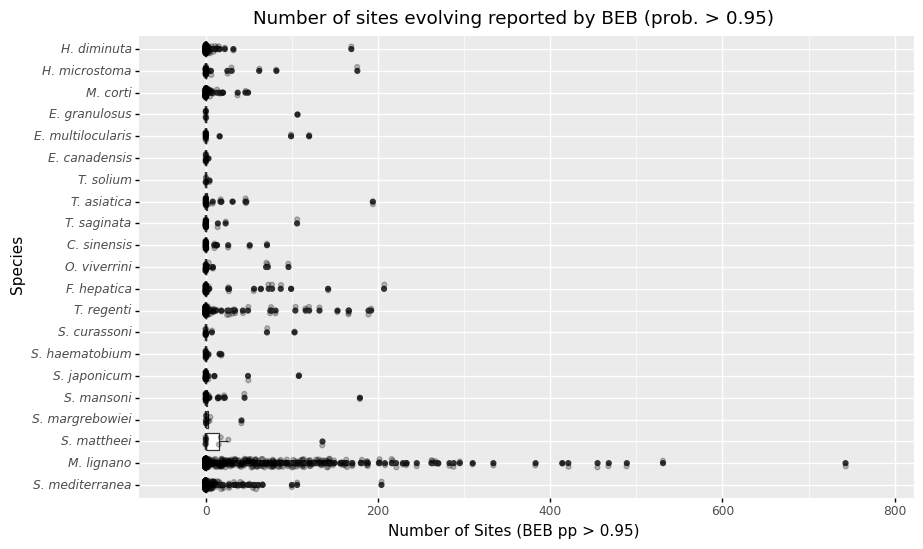

<ggplot: (-9223363309845973651)>

In [12]:


# Determine the range for y-axis limits
min_y = df_m2.query("dS > 0.1")['Num. sites (BEB pp > 0.95)'].min()
max_y = df_m2.query("dS > 0.1")['Num. sites (BEB pp > 0.95)'].max()
buffer = (max_y - min_y) * 0.05  # Adding a 5% buffer

# Create the boxplot
plot = (ggplot(df_m2.query("dS > 0.1"), aes(x='Species', y='Num. sites (BEB pp > 0.95)'))
        + geom_boxplot()
        + geom_point(alpha=0.25, position=position_jitter(width=0.2))
        + coord_flip()  # Make the plot horizontal
        + theme(axis_text_y=element_text(hjust=1, style='italic'),  # Rotate and italicize x-axis text
                figure_size=(10, 6))  # Adjust figure size
        + labs(title='Number of sites evolving reported by BEB (prob. > 0.95)',
               x='Species',
               y='Number of Sites (BEB pp > 0.95)')
        + scale_y_continuous(breaks=np.arange(min_y - buffer, max_y + buffer + 1, 1))  # Adjusted line
        + ylim(min_y - buffer, max_y + buffer + 1))  # Set y-axis limits with buffer

plot

In [13]:
# saving plot
plot.save('../results/figures/supplementary_figure_9c.svg')

/home/mauricio/anaconda3/envs/r-environment/lib/python3.6/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 10 x 6 in image.
/home/mauricio/anaconda3/envs/r-environment/lib/python3.6/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../results/figures/supplementary_figure_9c.svg


## Distribution of dN/dS calculation for inparalogous groups

In [14]:
import concurrent

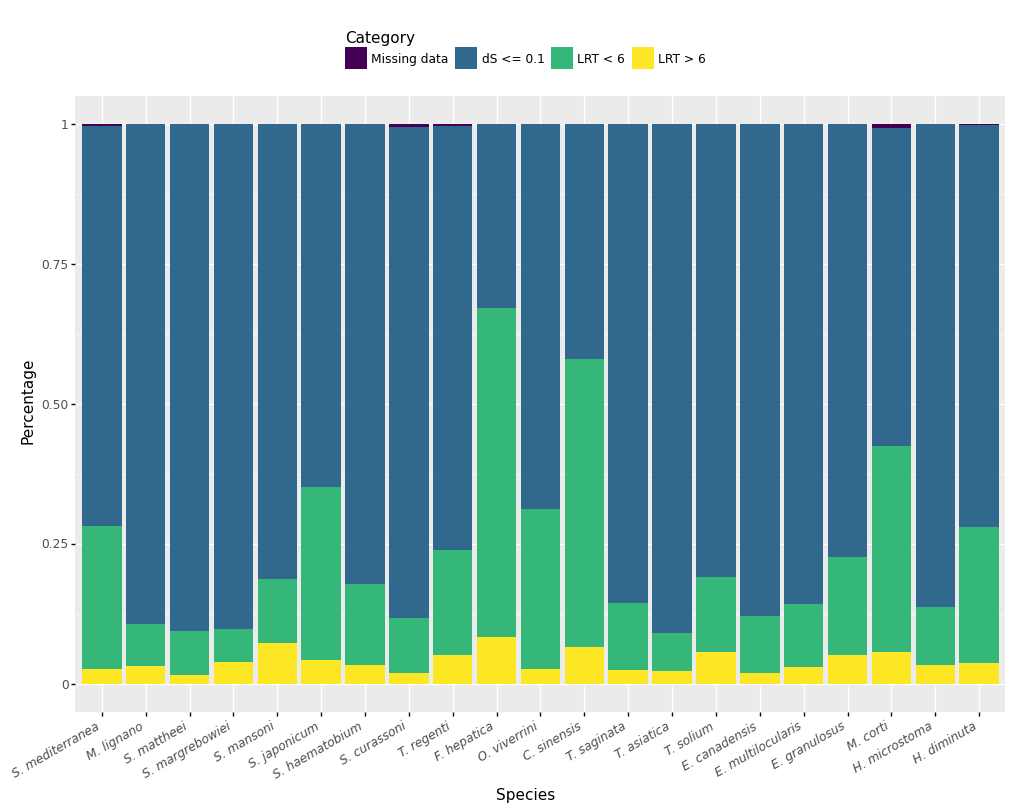

In [15]:
import pandas as pd
import numpy as np
import glob
from plotnine import ggplot, aes, geom_bar, labs, coord_flip, theme, element_text
from concurrent.futures import ThreadPoolExecutor

# Function to process each species
def process_species_data(species_group):
    species_name, species_data = species_group
    # Initialize a series with zeros for all categories
    category_counts = pd.Series(0, index=categories)

    # Count the number of occurrences for each category in this species group
    counts = species_data['Type'].value_counts()
    category_counts.update(counts)

    # Calculate percentage
    category_percentage = (category_counts / category_counts.sum()) * 100
    category_percentage.name = species_name
    return category_percentage

# Load your DataFrame
# df = pd.read_csv('your_data.csv')  # Replace with your actual data loading code

# Define categories and conditions
categories = ['Missing data', 'dS <= 0.1', 'LRT < 6', 'LRT > 6']
conditions = [
    (df['dS'].isna() | df['Likelihood_ratio'].isna()),
    (df['dS'] <= 0.1),
    (df['Likelihood_ratio'] < 6),
    (df['Likelihood_ratio'] > 6)
]

# Apply conditions to assign categories
df['Type'] = np.select(conditions, categories, default='Missing data')

# Aggregate data by Species and Type, and calculate the percentage
with ThreadPoolExecutor(max_workers=32) as executor:
    # Group the DataFrame by 'Species' and apply processing in parallel
    groups = df.groupby('Species')
    results = list(executor.map(process_species_data, groups))

# Combine the results into a DataFrame
category_percentages = pd.DataFrame(results)

# Ensure the order of species is correct
species_order = df['Species'].unique()
category_percentages = category_percentages.reindex(species_order)

# Melt the dataframe for plotting
melted_df = category_percentages.reset_index().melt(id_vars='index', var_name='Type', value_name='value')

# Define the order of categories
category_order = ['Missing data', 'dS <= 0.1', 'LRT < 6', 'LRT > 6']

# Convert 'Type' to a categorical type with the specified order
melted_df['Type'] = pd.Categorical(melted_df['Type'], categories=category_order, ordered=True)

# Plot
plot = (ggplot(melted_df, aes(x='index', y='value', fill='Type'))
        + geom_bar(stat='identity', position='fill')
        + labs(x='Species', y='Percentage', fill='Category')
        #+ coord_flip()
        + theme(axis_text_x=element_text(rotation=30, hjust=1, style='italic'), 
                figure_size=(12, 8),
                legend_position='top')
       )

# Display the plot
print(plot)

In [16]:
plot.save('../results/figures/supplementary_figure_9a.svg')

/home/mauricio/anaconda3/envs/r-environment/lib/python3.6/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 12 x 8 in image.
/home/mauricio/anaconda3/envs/r-environment/lib/python3.6/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../results/figures/supplementary_figure_9a.svg


In [17]:
glob.glob('../results/molecular_evolution_analyses/codeml_results/F65372_MLIG_G1/F65372_MLIG_G1/M2~c75ab97a0d1c097125cdd7b4a459ebeb/*')

['../results/molecular_evolution_analyses/codeml_results/F65372_MLIG_G1/F65372_MLIG_G1/M2~c75ab97a0d1c097125cdd7b4a459ebeb/2NG.dS',
 '../results/molecular_evolution_analyses/codeml_results/F65372_MLIG_G1/F65372_MLIG_G1/M2~c75ab97a0d1c097125cdd7b4a459ebeb/lnf',
 '../results/molecular_evolution_analyses/codeml_results/F65372_MLIG_G1/F65372_MLIG_G1/M2~c75ab97a0d1c097125cdd7b4a459ebeb/2NG.t',
 '../results/molecular_evolution_analyses/codeml_results/F65372_MLIG_G1/F65372_MLIG_G1/M2~c75ab97a0d1c097125cdd7b4a459ebeb/rub',
 '../results/molecular_evolution_analyses/codeml_results/F65372_MLIG_G1/F65372_MLIG_G1/M2~c75ab97a0d1c097125cdd7b4a459ebeb/out',
 '../results/molecular_evolution_analyses/codeml_results/F65372_MLIG_G1/F65372_MLIG_G1/M2~c75ab97a0d1c097125cdd7b4a459ebeb/tmp.ctl',
 '../results/molecular_evolution_analyses/codeml_results/F65372_MLIG_G1/F65372_MLIG_G1/M2~c75ab97a0d1c097125cdd7b4a459ebeb/tree',
 '../results/molecular_evolution_analyses/codeml_results/F65372_MLIG_G1/F65372_MLIG_G1/

## Histogram of dN/dS values

In [34]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_bar, labs, coord_flip, theme, element_text
import glob

# Assuming 'df' is your DataFrame with the data
# df = pd.read_csv('path_to_your_data.csv')  # Uncomment and set path to your data

# Define categories and their boundaries
bins = [0, 0.25, 0.5, 0.75, 1, np.inf]
labels = ['0-0.25', '0.25-0.5', '0.5-0.75', '0.75-1', '>1']

# Define categories and their boundaries
categories = [
    (0, 0.25, '0-0.25'),
    (0.25, 0.5, '0.25-0.5'),
    (0.5, 0.75, '0.5-0.75'),
    (0.75, 1, '0.75-1'),
    (1, np.inf, '>1')
]

# Filter out the rows where dS <= 0.1
df_filtered = df[df['dS'] > 0.1].copy()

# Initialize the category column
df_filtered['dNdS_category'] = '>1'  # Default to the last category

# Manually categorize dN/dS ratios
for lower, upper, label in categories:
    df_filtered.loc[df_filtered['dN/dS'].between(lower, upper, inclusive="left"), 'dNdS_category'] = label


# Group by 'Species' and 'dN/dS_category' to get the count for each category
counts = df_filtered.groupby(['Species', 'dNdS_category']).size().unstack(fill_value=0)

In [35]:
import seaborn as sns

In [36]:
df_filtered

,Family,Model,Degrees of freedom,LnL,# sites (BEB pp > 0.95),# sites (BEB pp > 0.99),dN,dS,dN/dS,Num. sites (BEB pp > 0.95),Num. sites (BEB pp > 0.99),index,Likelihood_ratio,Significativo,Species,Type,dNdS_category
12,F27079_MLIG_G1,M1,7.0,-1054.568488,0,0,1.4177,1.8216,0.7783,NaN,NaN,7771,21.504700,***,M. lignano,LRT > 6,0.75-1
13,F27079_MLIG_G1,M2,9.0,-1043.816138,0,0,17.8260,0.3758,47.4361,51.0,36.0,7771,21.504700,***,M. lignano,LRT > 6,>1
18,F109937_SMED_G1,M1,5.0,-270.918569,0,0,2.6432,52.3292,0.0505,NaN,NaN,1642,0.000006,-,S. mediterranea,LRT < 6,0-0.25
19,F109937_SMED_G1,M2,7.0,-270.918566,0,0,2.6427,52.3305,0.0505,0.0,0.0,1642,0.000006,-,S. mediterranea,LRT < 6,0-0.25
28,F71368_SHAE_G1,M1,5.0,-2035.776729,0,0,2.2658,102.9831,0.0220,NaN,NaN,15164,-0.362680,-,S. haematobium,LRT < 6,0-0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39761,F109182_TSAG_G1,M1,5.0,-396.631060,0,0,0.3044,0.8137,0.3741,NaN,NaN,1502,51.540808,***,T. saginata,LRT > 6,0.25-0.5
39766,F84335_MLIG_G1,M1,6.0,-4973.871884,0,0,13.7580,26.3956,0.5212,NaN,NaN,17272,149.991356,***,M. lignano,LRT > 6,0.5-0.75
39767,F84335_MLIG_G1,M2,8.0,-4898.876206,0,0,21.1810,2.3708,8.9342,67.0,3.0,17272,149.991356,***,M. lignano,LRT > 6,>1
39782,F129217_MLIG_G1,M2,9.0,-1711.561286,0,0,9.3191,0.7274,12.8117,74.0,34.0,4971,12.489600,***,M. lignano,LRT > 6,>1


In [39]:
df_filtered_plot = df_filtered.rename({'dN/dS': 'Global dN/dS'}, axis = 1)

In [40]:
import rpy2

In [41]:
%load_ext rpy2.ipython

In [42]:
%%R -i df_filtered_plot

library(magrittr)
library(ggridges)
library(tidyverse)

tabla_dnds = df_filtered_plot %<>% as_tibble()

final_plot = tabla_dnds %>%
  # binning data
  #dplyr::mutate(dN_dS_mlc2 = case_when(dN_dS_mlc2 == 0 ~ '0 - 0.3', 
  #                                     between(dN_dS_mlc2, 0, 0.3) ~ '0 - 0.3', 
  #                                     between(dN_dS_mlc2, 0.3, 0.6) ~ '0.3 - 0.6', 
  #                                     between(dN_dS_mlc2, 0.6, 0.9) ~ '0.6 - 0.9' , 
  #                                     between(dN_dS_mlc2, 0-9, 1.1) ~ '0.9 - 1.1' , 
  #                                     dN_dS_mlc2 >= 1.1 ~ '>1.1')) %>% 
  dplyr::mutate(`Global dN/dS` = case_when(between(`Global dN/dS`, 0, 1.0) ~ `Global dN/dS`, 
                                       `Global dN/dS` > 1.0 ~ 1.1)) %>% 
  ggplot(data = ., mapping = aes(x = `Global dN/dS`)) +
  #geom_col() +
  #xlim(0, 1.100001) +
  #geom_tile() +
  #ggridges::geom_density_ridges(mapping = aes(x = dN_dS_mlc2, y = Species), 
  #                              stat = 'density', scale = 0.9) +
  theme(axis.text.y = element_text(hjust = 1.0, face = c("italic"))) +
  ggridges::geom_density_ridges(mapping = aes(x = `Global dN/dS`, y = Species), 
                                stat = 'binline', scale = 0.75, binwidth = 0.25) +
  #ggplot2::scale_x_binned(breaks = c(0, 0.3)) +
  #geom_histogram(breaks = c(0, 0.3, 0.6, 0.9, 1.1), aes(y = stat(density))) +
  labs(title = "Supplementary Figure 8: dN/dS distribution among species") +
  xlab('dN/dS') +
  scale_x_continuous(breaks = c(0, 0.25, 0.5, 0.75, 1.0), labels = c('0 - 0.25', '0.25 - 0.50', '0.50 - 0.75', '0.75 - 1.0', '> 1.0'))
  #facet_wrap(~Class+Species, dir = 'v')

  # saving plot to results folder
  ggplot2::ggsave(filename = '../results/figures/supplementary_figure9b.pdf', final_plot, height = 12, width = 12)


R[write to console]: ── Attaching packages ─────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

R[write to console]: ── Conflicts ────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names() masks magrittr::set_names()



In [ ]:
# Melt the DataFrame to long format for plotting
melted = proportions.melt(id_vars='Species', var_name='dN/dS_category', value_name='value')

# Define the order of categories
category_order = ['0-0.25', '0.25-0.5', '0.5-0.75', '0.75-1', '>1']

# Convert 'dN/dS_category' to categorical with the specified order for plotting
melted['dN/dS_category'] = pd.Categorical(melted['dN/dS_category'], categories=category_order, ordered=True)

# Plot
plot = (ggplot(melted, aes(x='Species', y='value', fill='dN/dS_category'))
        + geom_bar(stat='identity', position='fill')
        + labs(x='', y='Proportion', fill='Category')
        + coord_flip()
        + theme(axis_text_y=element_text(rotation=0, hjust=1, style='italic'), 
                figure_size=(10, 12),
                legend_title=element_text(size=10), 
                legend_text=element_text(size=8),
                legend_position='right')
       )

# Display the plot
print(plot)
